In [1]:
import math
import pandas_datareader as pdr
import pandas as pd
import numpy as np

from datetime import datetime
# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 
# for tsa 
import statsmodels.api as sm
# holt's linear trend model. 
from statsmodels.tsa.api import Holt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [2]:
#get the stock quote
df = pdr.DataReader("SPY",data_source = "yahoo", start = "2009-01-01", end = "2021-12-31")
df.shape

(3273, 6)

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-01-02,93.440002,89.849998,90.440002,92.959999,227566300.0,71.532005
2009-01-05,93.660004,91.889999,92.629997,92.849998,240349700.0,71.447380
2009-01-06,94.449997,92.680000,93.639999,93.470001,328260900.0,71.924500
2009-01-07,92.260002,90.199997,92.000000,90.669998,280899200.0,69.769882
2009-01-08,91.089996,89.669998,90.160004,91.040001,263834400.0,70.054596


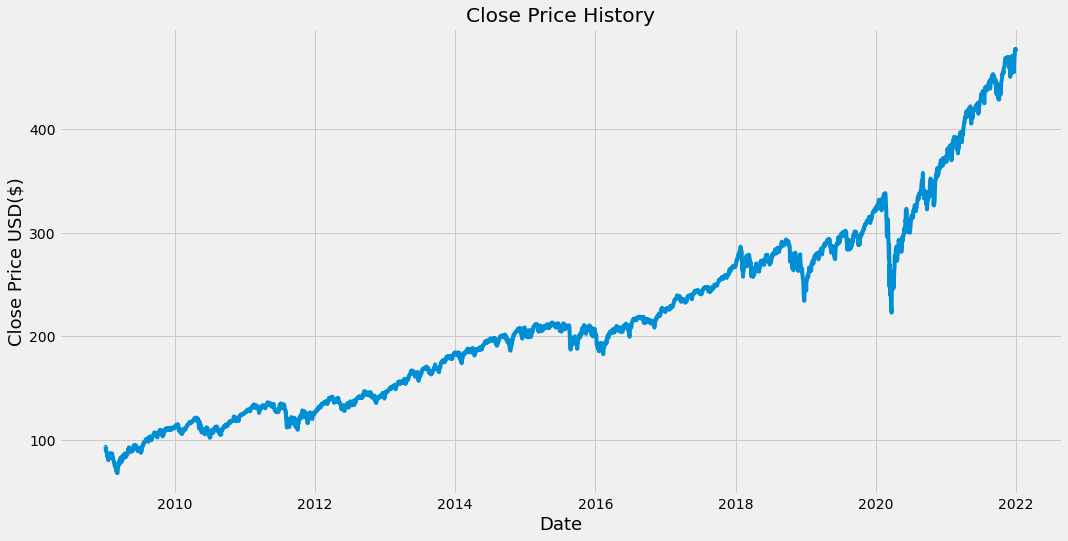

In [4]:
# visualize some f the data
plt.figure(figsize =(16,8))
plt.title("Close Price History")
plt.plot(df["Close"])
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price USD($)", fontsize = 18)
plt.show()

In [5]:
# create new dataframe with only close column
data = df.filter(["Close"])

In [6]:
# set train size to be 50% of total 
train_size = (math.ceil(data.shape[0] * 0.5))
train_size 


1637

In [7]:
# set validate size to be 30% of total 
validate_size = int(round(data.shape[0] * 0.3))
validate_size 

982

In [8]:
# set test size to be number of rows remaining. 
test_size = int(round(data.shape[0] * 0.2))
test_size

655

In [9]:
df.shape,train_size+validate_size+test_size

((3273, 6), 3274)

In [10]:
# validate will go from 912 to 912+547
validate_end_index = train_size + validate_size
validate_end_index

2619

In [11]:
# train will go from 0 to 1259
train = data[:train_size]

In [12]:
# train will go from 1259 to 2014

validate = data[train_size:validate_end_index]

In [13]:
# test will include 2014 to the end 2517
test = data[validate_end_index:]
test.shape


(654, 1)

In [14]:
train.shape[0], validate.shape[0], test.shape[0]

(1637, 982, 654)

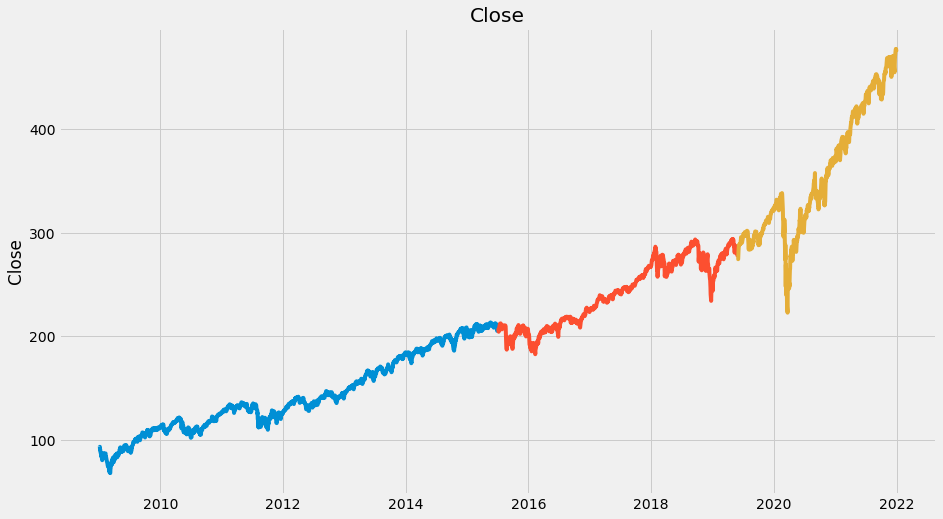

In [15]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [16]:
# brings end of year and frequency
# finding minimum value for end of year for all columns and rows
train.resample(rule = "A").min()

,Close
Date,
2009-12-31,68.110001
2010-12-31,102.199997
2011-12-31,109.930000
2012-12-31,127.500000
2013-12-31,145.550003
2014-12-31,174.169998
2015-12-31,199.020004


<AxesSubplot:xlabel='Date'>

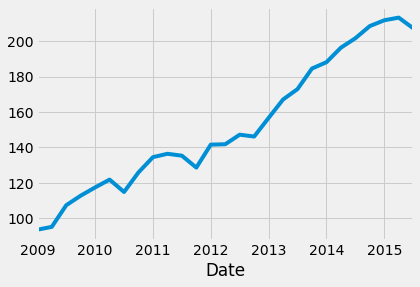

In [17]:
# quaterly movement
train.resample(rule = "QS").max()["Close"].plot()

In [18]:
#business endof year frequency
train.resample(rule = "BA").max()

,Close
Date,
2009-12-31,112.720001
2010-12-31,125.919998
2011-12-30,136.429993
2012-12-31,147.240005
2013-12-31,184.690002
2014-12-31,208.720001
2015-12-31,213.500000


<AxesSubplot:xlabel='Date'>

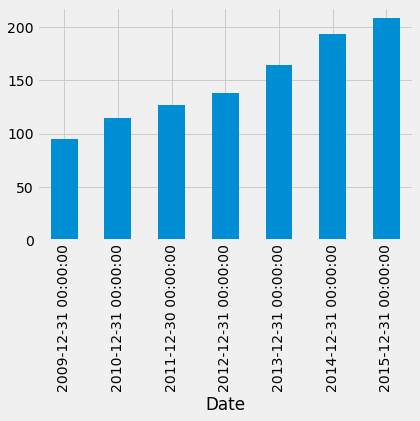

In [19]:
# plotting yearly data 
train["Close"].resample(rule = "BA").mean().plot(kind = "bar")

<AxesSubplot:xlabel='Date'>

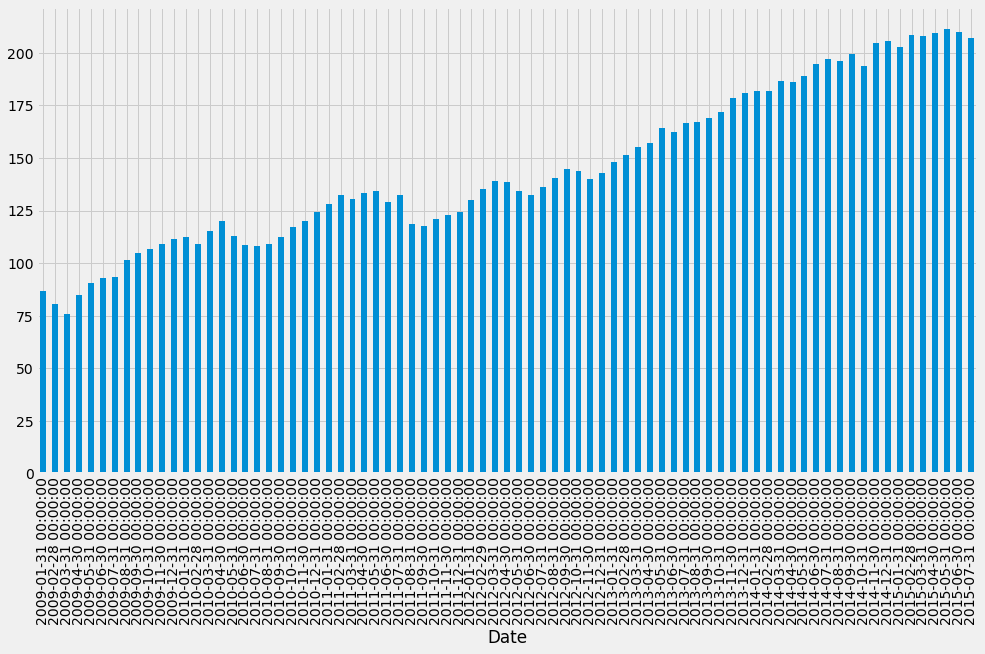

In [20]:
# plotting monthly data
train["Close"].resample(rule = "M").mean().plot(kind = "bar",figsize = (15, 8))

In [37]:
#simple moving average (first move by the rolling digit then+ 1 after the initial move),kinda smoothening curve
train["sma"] =train ["Close"].rolling(window = 20, min_periods =1).mean()


<AxesSubplot:xlabel='Date'>

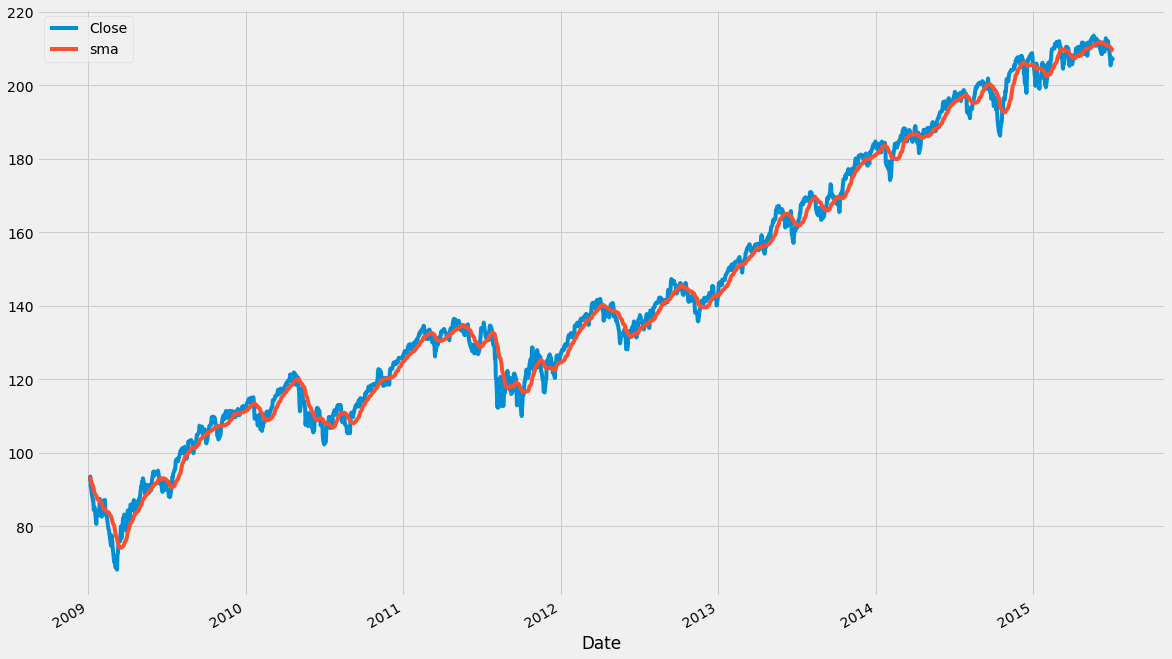

In [38]:
 train.plot( figsize = (18,12))


# Scaling

In [23]:
# convert df to np array
dataset = data.values
# get number of rows to train
training_data_len = math.ceil(len(dataset)*0.5)
training_data_len

1637

In [24]:
#scale the data using a min max scaler 
scaler = MinMaxScaler(feature_range= (0,1))
scaled_data = scaler.fit_transform(dataset)


In [25]:
train = train[["Close"]]
train.head()

,Close
Date,
2009-01-02,92.959999
2009-01-05,92.849998
2009-01-06,93.470001
2009-01-07,90.669998
2009-01-08,91.040001


In [26]:
# create training data set 
# create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

# split data into x and y train data
x_train = []
y_train = []
for i in range (60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i, 0])
    if i <= 60:
        print(x_train)
        print(y_train)
        print()

[array([0.06070303, 0.06043432, 0.06194885, 0.05510906, 0.0560129 ,
       0.05124947, 0.04602193, 0.04641278, 0.03971957, 0.03979285,
       0.04140508, 0.03043701, 0.03893789, 0.03576227, 0.03664167,
       0.03803405, 0.04011041, 0.04709675, 0.04015927, 0.03595769,
       0.035347  , 0.03818061, 0.03717908, 0.04020812, 0.04609523,
       0.04638835, 0.03664167, 0.03783862, 0.0379852 , 0.0357867 ,
       0.02713926, 0.02667513, 0.02459877, 0.02274226, 0.01597577,
       0.02288884, 0.02139874, 0.01834527, 0.01421697, 0.00608251,
       0.00478784, 0.00884286, 0.00168552, 0.00197864, 0.        ,
       0.00991767, 0.01106578, 0.01805213, 0.01949336, 0.01893153,
       0.02459877, 0.02887363, 0.02645529, 0.02100789, 0.0344676 ,
       0.03051029, 0.03258665, 0.03664167, 0.0329775 , 0.02608887])]
[0.027872085750090952]



In [27]:
# convert x_and y_train dataset to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [28]:
x_train.shape , y_train.shape

((1577, 60), (1577,))

# Modeling LSTM

#### reshape data to 3 dimensional

In [29]:
#reshape the data because LSTM expecting the data to be 3 diemsional
#ssamples timesets and features
x_train=np.reshape(x_train, (x_train.shape[0],60,1))
x_train.shape

(1577, 60, 1)

In [30]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

2022-07-01 07:08:49.437153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
# compile the model( to measure how well the model did on training)
model.compile(optimizer = "adam", loss= "mean_squared_error")

In [32]:
# train the model, epoch is number of itterations
model.fit(x_train, y_train, batch_size=1,epochs = 1)

1577/1577 [==============================] - 56s 34ms/step - loss: 2.3833e-04


In [33]:
# create the testing data set... 
# create new array containing scaled values from index to 1199 to 2003
test_data=scaled_data[training_data_len - 60:, :]

In [34]:
# create the dataset x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range (60,len(test_data)):
    x_test.append(test_data[i-60: i, 0])
    

In [39]:
# convert data to numpy array
# x_test